## Reddit data-set for sarcasm detection (pt 1)

The Sarcasm on Reddit dataset provides comments posted on Reddit labeled as sarcastic (1) or not sarcastic (0).
The task of the project is, given only the parent comment and the Reddit category (subreddit), to predict the probability of a parent comment to receive a sarcastic comment.

Download the dataset and unzip it.

In [1]:
#import kaggle
#kaggle.api.authenticate()
#kaggle.api.dataset_download_files('danofer/sarcasm', unzip=True)

In [2]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression as lg
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib
from matplotlib import pyplot as plt
from scipy.sparse import hstack
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [3]:
import tensorflow as tf
import os
from tensorflow import keras

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


In [4]:
# Importing the Keras libraries and packages
from keras import backend as K
from keras.utils import to_categorical
from keras.layers import Dense, ZeroPadding2D, AveragePooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import InceptionResNetV2
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [5]:
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()

## Data-set analysis

We import the data and analyze it.

As the creator of the dataset states the Reddit dataset contains 1.3 million Sarcastic comments from the Internet commentary website Reddit and it was generated by scraping comments from Reddit containing the \s (sarcasm) tag. This tag is often used by Redditors to indicate that their comment is in jest and not meant to be taken seriously, and is generally a reliable indicator of sarcastic comment content.

In [6]:
red = pd.read_csv('C:/Users/liry9/Desktop/Text Mining and Sentiment Analysis/Project/Dataset/train-balanced-sarcasm.csv')
red.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",SoupToPots,pcmasterrace,1,-1,-1,2016-10,2016-10-27 19:11:06,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,chihawks,Lollapalooza,2,-1,-1,2016-11,2016-11-21 23:39:12,Probably count Kanye out Since the rest of his...


In [7]:
print(red.shape[0])  # gives number of row count
print(red.shape[1])  # gives number of col count

1010826
10


In [8]:
print(red['parent_comment'][5])
print(red['comment'][5])
print(red['label'][5])

do you find ariana grande sexy ?
I don't pay attention to her, but as long as she's legal I wouldn't kick her out of bed (before she took a load)
0


The analysis will begin by focusing on a small sample of the dataset since as it is possible to observe from the previous command the dataset (not yet pre-processed) contains 1010826 rows, 962295 unique values (as for what concerns the comments' column) and 984286 unique values (for the parent comment section). The difference between the total number of rows of the data frame, that of the comments and the ones of the parent comments implies that there are some nan values. As a matter of fact:

In [9]:
red.isnull().sum() # There are 53 nan values for the comments' column

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [10]:
red = red[red['comment'].notna()]
red.isnull().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [11]:
red_sample = red.sample(frac = 0.05) ## Since the original dataset is huge, we will work with a small sample of it
print(red_sample.shape[0])  # gives number of row count
print(red_sample.shape[1])  # gives number of col count

50539
10


In [12]:
## Let's check the number of unique values in the label columns: this operation should confirm that we only have two labels:
# 0 = non sarcastic comment
# 1 = sarcastic comment
red_sample['label'].nunique()

2

Based on the information given by its owner the dataset should be balanced, this however an analysis of the distribution of the labels will follow, in order to check whether we need to adjust the class distribution of our dataset using adapting techniques such as oversampling or undersampling.

C:\Users\liry9\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

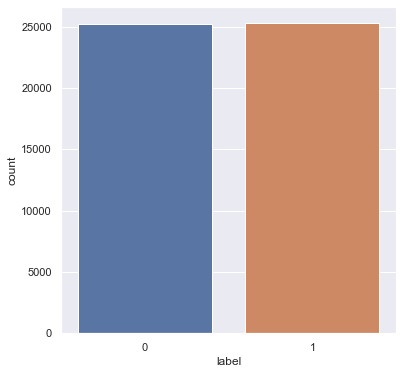

In [13]:
sns.set(rc={'figure.figsize':(6,6)})
sns.countplot(red_sample['label']) # The dataset, or in this case the sample, is confirmed to be balanced

Let's consider one comment to undrstand tokenization, lemmatization, stopwords removal and POS tagging.

In [14]:
example = red['parent_comment'][0]

In [15]:
example

"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well."

In [16]:
example_comment = red['comment'][0]

In [17]:
example_comment

'NC and NH.'

In [18]:
example_label = red['label'][0]
example_label

0

In [19]:
## Example of SENTENCE tokenization
from nltk.tokenize import sent_tokenize
tokenized_sentence_example = sent_tokenize(example)
print(tokenized_sentence_example)

['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]


In [20]:
## Example of WORD tokenization
from nltk.tokenize import word_tokenize
tokenized_word_example = word_tokenize(example)
print(tokenized_word_example)

['Yeah', ',', 'I', 'get', 'that', 'argument', '.', 'At', 'this', 'point', ',', 'I', "'d", 'prefer', 'is', 'she', 'lived', 'in', 'NC', 'as', 'well', '.']


In [21]:
## Word frequency distribution
from nltk.probability import FreqDist
freqDistrib = FreqDist(tokenized_word_example)
print(freqDistrib)

<FreqDist with 19 samples and 22 outcomes>


In [22]:
freqDistrib.most_common(3)

[(',', 2), ('I', 2), ('.', 2)]

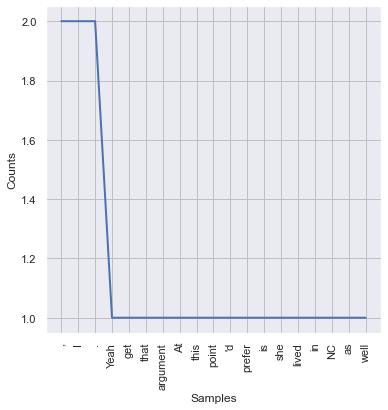

In [23]:
freqDistrib.plot(30,cumulative=False)
plt.show()

In [24]:
stop_words=set(stopwords.words("english"))
print(stop_words)

{'which', "you'll", 'after', 'on', 'its', 'each', 'just', "she's", 'won', 'why', 'any', 'a', "should've", 'too', 'it', 'should', 'she', 'their', 'couldn', 'those', "shouldn't", 'nor', 'doesn', 'will', 'because', 'so', "doesn't", "wouldn't", 's', 'yourself', 'own', 'above', 'you', "hadn't", 'no', 'y', 'his', 'have', 'weren', 'further', 'our', 'an', 'off', 'shan', 'didn', 'during', "wasn't", 'if', "aren't", 'all', 'this', 'whom', 'ourselves', 'such', 'at', 'now', 'o', 're', 'her', 'your', 'when', 'himself', 'aren', "weren't", 'where', 'of', 'how', 'mightn', 'below', 'than', 'they', 'some', 'am', 'who', 'yours', 'in', 'ma', "mightn't", 'themselves', 'mustn', 'against', 'hadn', "that'll", 'i', 'we', 'once', "you're", 'he', 'and', 'not', 'did', 'about', 'few', 'the', 'wasn', 'only', 'do', "couldn't", 'very', 'most', 'but', 'is', 'are', 'him', 'by', 'ours', 'myself', "needn't", 'shouldn', 'm', "hasn't", 'same', 'there', 'as', 'from', "isn't", 'was', 'has', 'up', "won't", 'd', 'wouldn', 'been

In [25]:
filteredSentence = []
for w in tokenized_sentence_example:
    if w not in stop_words:
        filteredSentence.append(w)
print("Tokenized Sentence:",tokenized_sentence_example)
print("Filterd Sentence:",filteredSentence)

Tokenized Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]
Filterd Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]


In [26]:
## Stemming
from nltk.stem import PorterStemmer

stemmedWords=[]
for w in filteredSentence:
    stemmedWords.append(PorterStemmer().stem(w))

print("Filtered Sentence:",filteredSentence)
print("Stemmed Sentence:",stemmedWords)

Filtered Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]
Stemmed Sentence: ['yeah, i get that argument.', "at this point, i'd prefer is she lived in nc as well."]


In [27]:
## Lemmatization
from nltk.stem.wordnet import WordNetLemmatizer

word = "pretty"
print("Lemmatized Word:",WordNetLemmatizer().lemmatize(word))
print("Stemmed Word:",PorterStemmer().stem(word))

Lemmatized Word: pretty
Stemmed Word: pretti


In [28]:
## POS tagging
nltk.download('averaged_perceptron_tagger')
nltk.pos_tag(tokenized_word_example)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\liry9\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('Yeah', 'UH'),
 (',', ','),
 ('I', 'PRP'),
 ('get', 'VBP'),
 ('that', 'DT'),
 ('argument', 'NN'),
 ('.', '.'),
 ('At', 'IN'),
 ('this', 'DT'),
 ('point', 'NN'),
 (',', ','),
 ('I', 'PRP'),
 ("'d", 'MD'),
 ('prefer', 'VB'),
 ('is', 'VBZ'),
 ('she', 'PRP'),
 ('lived', 'VBD'),
 ('in', 'IN'),
 ('NC', 'NNP'),
 ('as', 'RB'),
 ('well', 'RB'),
 ('.', '.')]

### Dpendency parser

In [29]:
nlp = spacy.load("en_core_web_sm")

In [30]:
from spacy import displacy

In [31]:
s_example = nlp(example)

In [32]:
displacy.render(s_example, style='dep')

## Distribution of sarcastic and non sarcastic comments

In order to compute what is the probability that given only the subreddit and the parent comment, the parent comment is associated with a sarcastic comment it is necessary to drop all the other columns.

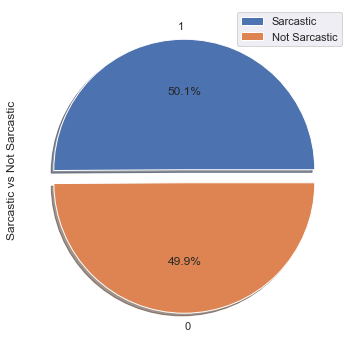

In [33]:
# Pie chart
red_sample["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Sarcastic vs Not Sarcastic")
plt.legend(["Sarcastic", "Not Sarcastic"])
plt.show()

### Exploratory Analysis

It might be interesting to perform some exploratory analysis on the dataset.

In [34]:
## Number of unique comment author
red_sample['author'].nunique()

42063

In [35]:
## Number of unique subreddit
red_sample['subreddit'].nunique()

4068

In [36]:
# Create a copy of the original dataset
red_copy = red_sample.copy()

Focusing on the column of the comments.

In [37]:
## Group and count the comments by author and label
red_sample.groupby(['author', 'label'],as_index=False).agg({'comment':'count'})

,author,label,comment
0,------___--___------,0,1
1,-----BroAway-----,1,1
2,---Earth---,0,2
3,---Earth---,1,1
4,--Danger--,1,1
...,...,...,...
45992,zzVoidBombzz,1,1
45993,zzed_41,1,2
45994,zzrosscozz,0,1
45995,zzt711,0,1


In [38]:
## Return the number of sarcastic comment per each author
sarcasm_count_by_author = red_sample.groupby('author')['label'].agg([np.sum])
sarcasm_count_by_author

,sum
author,
------___--___------,0
-----BroAway-----,1
---Earth---,1
--Danger--,1
--TaCo--,0
...,...
zzVoidBombzz,1
zzed_41,2
zzrosscozz,0


In [39]:
## Group and count the comments by author
comment_count_by_author = red_sample.groupby(['author'],as_index=False).agg({'comment':'count'})
comment_count_by_author

,author,comment
0,------___--___------,1
1,-----BroAway-----,1
2,---Earth---,3
3,--Danger--,1
4,--TaCo--,1
...,...,...
42058,zzVoidBombzz,1
42059,zzed_41,2
42060,zzrosscozz,1
42061,zzt711,1


In [40]:
comment_sum_up = pd.merge(sarcasm_count_by_author, comment_count_by_author, on='author')
comment_sum_up

,author,sum,comment
0,------___--___------,0,1
1,-----BroAway-----,1,1
2,---Earth---,1,3
3,--Danger--,1,1
4,--TaCo--,0,1
...,...,...,...
42058,zzVoidBombzz,1,1
42059,zzed_41,2,2
42060,zzrosscozz,0,1
42061,zzt711,0,1


In [41]:
comment_sum_up['percentage of sarcastic comments'] = comment_sum_up['sum']/comment_sum_up['comment']
comment_sum_up

,author,sum,comment,percentage of sarcastic comments
0,------___--___------,0,1,0.000000
1,-----BroAway-----,1,1,1.000000
2,---Earth---,1,3,0.333333
3,--Danger--,1,1,1.000000
4,--TaCo--,0,1,0.000000
...,...,...,...,...
42058,zzVoidBombzz,1,1,1.000000
42059,zzed_41,2,2,1.000000
42060,zzrosscozz,0,1,0.000000
42061,zzt711,0,1,0.000000


In [42]:
## Most sarcastic author:
print("The most sarastic author is: %15s" % (comment_count_by_author['author'].loc[comment_count_by_author['comment'].idxmax()]))

The most sarastic author is:     Biffingston


Some further analysis

In [43]:
## Group and count the comments by author and label
red_sample.groupby(['subreddit', 'label'],as_index=False).agg({'comment':'count'})

,subreddit,label,comment
0,100pushups,0,1
1,1022,1,1
2,10cloverfieldlane,0,1
3,10cloverfieldlane,1,1
4,112263Hulu,0,1
...,...,...,...
5740,zen,1,1
5741,zenfone2,0,2
5742,zoology,1,1
5743,zootopia,0,1


In [44]:
## Return the number of sarcastic comment per each subreddit
sarcasm_count_by_subreddit = red_sample.groupby('subreddit')['label'].agg([np.sum])
sarcasm_count_by_subreddit

,sum
subreddit,
100pushups,0
1022,1
10cloverfieldlane,1
112263Hulu,0
1200isplenty,1
...,...
zelda,7
zen,1
zenfone2,0


In [45]:
## Group and count the comments by author
comment_count_by_subreddit = red_sample.groupby(['subreddit'],as_index=False).agg({'comment':'count'})
comment_count_by_subreddit

,subreddit,comment
0,100pushups,1
1,1022,1
2,10cloverfieldlane,2
3,112263Hulu,1
4,1200isplenty,1
...,...,...
4063,zelda,7
4064,zen,3
4065,zenfone2,2
4066,zoology,1


In [46]:
subreddit_comment_sum_up = pd.merge(sarcasm_count_by_subreddit, comment_count_by_subreddit, on='subreddit')
subreddit_comment_sum_up

,subreddit,sum,comment
0,100pushups,0,1
1,1022,1,1
2,10cloverfieldlane,1,2
3,112263Hulu,0,1
4,1200isplenty,1,1
...,...,...,...
4063,zelda,7,7
4064,zen,1,3
4065,zenfone2,0,2
4066,zoology,1,1


In [47]:
subreddit_comment_sum_up['percentage of sarcastic comments'] = subreddit_comment_sum_up['sum']/subreddit_comment_sum_up['comment']
subreddit_comment_sum_up

,subreddit,sum,comment,percentage of sarcastic comments
0,100pushups,0,1,0.000000
1,1022,1,1,1.000000
2,10cloverfieldlane,1,2,0.500000
3,112263Hulu,0,1,0.000000
4,1200isplenty,1,1,1.000000
...,...,...,...,...
4063,zelda,7,7,1.000000
4064,zen,1,3,0.333333
4065,zenfone2,0,2,0.000000
4066,zoology,1,1,1.000000


In [48]:
## Most sarcastic subreddit
print("The most sarastic subreddit is: %15s" % (comment_count_by_subreddit['subreddit'].loc[comment_count_by_subreddit['comment'].idxmax()]))

The most sarastic subreddit is:       AskReddit


In [49]:
subreddits = red_sample['subreddit'].value_counts()

In [50]:
pd.DataFrame(subreddits)

,subreddit
AskReddit,3277
politics,1947
worldnews,1340
leagueoflegends,1051
pcmasterrace,965
...,...
RvBRP,1
airnationalguard,1
massachusetts,1
thedivisionclans,1


In [51]:
top_ten = subreddits.head(10)
top_ten = pd.DataFrame(top_ten)

In [52]:
top_ten['sub'] = top_ten.index

In [53]:
top_ten

,subreddit,sub
AskReddit,3277,AskReddit
politics,1947,politics
worldnews,1340,worldnews
leagueoflegends,1051,leagueoflegends
pcmasterrace,965,pcmasterrace
funny,847,funny
news,788,news
pics,784,pics
todayilearned,709,todayilearned
GlobalOffensive,698,GlobalOffensive


In [54]:
top_ten = top_ten.reset_index(drop=True)
top_ten

,subreddit,sub
0,3277,AskReddit
1,1947,politics
2,1340,worldnews
3,1051,leagueoflegends
4,965,pcmasterrace
5,847,funny
6,788,news
7,784,pics
8,709,todayilearned
9,698,GlobalOffensive


In [55]:
df = red_sample[red_sample.set_index(['subreddit']).index.isin(top_ten.set_index(['sub']).index)]
df = pd.DataFrame(df)

In [56]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
246442,1,"Come to think of it, ive never seen a non-Amer...",DeepOnTheOutside,worldnews,3,3,0,2016-05,2016-05-14 16:51:22,We've never once seen someone from the UK comm...
796949,0,The Mommy.,DostThowEvenLift,AskReddit,1,1,0,2014-07,2014-07-30 03:01:46,What movie would be made 200 times better by a...
711240,1,You're not unique.,Toasted_teag,AskReddit,1,1,0,2015-02,2015-02-07 00:17:34,Thats not unique lol
305830,1,What does it matter!,Uncle_Bill,politics,1,1,0,2016-07,2016-07-27 13:49:47,DNC Betrayed Bernie Sanders and the Rest of Am...
559961,1,There's *no way* that would be immediately and...,DonQuixBalls,news,4,4,0,2015-08,2015-08-08 02:06:05,No reason we can't make an exception for the a...


In [57]:
#df.loc[df.label == '1', df.subreddit == 'AskReddit'].count()
print(df[(df['label']==1) & (df['subreddit']=='AskReddit')].count())
print(df[(df['label']==0) & (df['subreddit']=='AskReddit')].count())

label             1379
comment           1379
author            1379
subreddit         1379
score             1379
ups               1379
downs             1379
date              1379
created_utc       1379
parent_comment    1379
dtype: int64
label             1898
comment           1898
author            1898
subreddit         1898
score             1898
ups               1898
downs             1898
date              1898
created_utc       1898
parent_comment    1898
dtype: int64


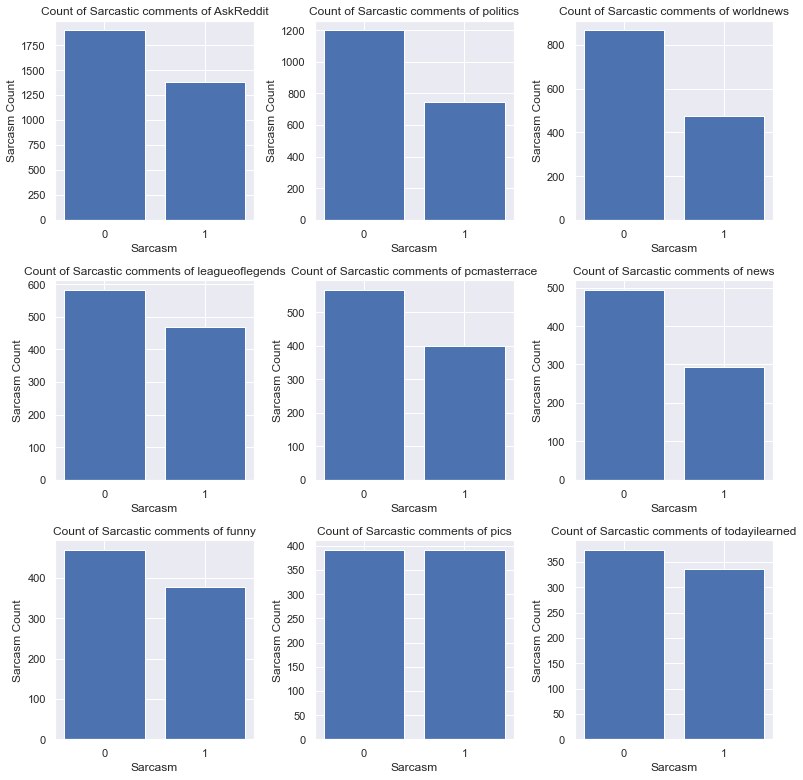

In [59]:
def plot_sub_sentiment(sub):
    dataFrame=df[df['subreddit']==sub]
    count=dataFrame['label'].value_counts()
    Index = [1,2]
    plt.bar(Index,count)
    plt.xticks(Index,['0','1'])
    plt.ylabel('Sarcasm Count')
    plt.xlabel('Sarcasm')
    plt.title('Count of Sarcastic comments of '+sub)
    plt.tight_layout()

plt.figure(1,figsize=(11, 11))
plt.subplot(331)
plot_sub_sentiment('AskReddit')
plt.subplot(332)
plot_sub_sentiment('politics')
plt.subplot(333)
plot_sub_sentiment('worldnews')
plt.subplot(334)
plot_sub_sentiment('leagueoflegends')
plt.subplot(335)
plot_sub_sentiment('pcmasterrace')
plt.subplot(337)
plot_sub_sentiment('funny')
plt.subplot(336)
plot_sub_sentiment('news')
plt.subplot(338)
plot_sub_sentiment('pics')
plt.subplot(339)
plot_sub_sentiment('todayilearned')

#plt.savefig('C:/Users/liry9/Desktop/Text Mining and Sentiment Analysis/Project/images/sarcasm_count_per_subreddit.pdf')

C:\Users\liry9\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Sarcastic comments for "GlobalOffensive"')]

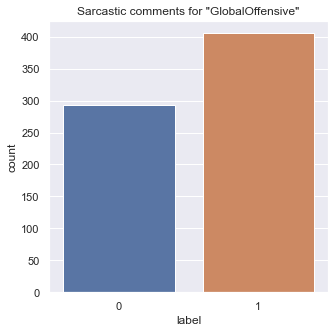

In [60]:
df_leagueoflegends = red_sample[red_sample['subreddit']==top_ten['sub'][9]]
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(df_leagueoflegends['label']).set(title = 'Sarcastic comments for "GlobalOffensive"')

Let's print out the highest and the lowest scores first and then the corresponding comment and parent comment.

In [61]:
print("The minimum score assigned to a comment is %d, while the highest one is %d" % (red_sample['score'].min(), red_sample['score'].max()))

The minimum score assigned to a comment is -261, while the highest one is 4909


In [62]:
print('The Parent Comment of the comment with the highest score is:\n',red_sample['parent_comment'].loc[red_sample['score'].idxmax()])
print('\n The Comment with the highest score is:\n',red_sample['comment'].loc[red_sample['score'].idxmax()])
if red_sample['label'].loc[red_sample['score'].idxmax()]==1:
    print('\n sarcastic')
else:
    print('\n not sarcastic')

The Parent Comment of the comment with the highest score is:
 What false facts are thought as real ones because of film industry? Movies, tv series... You name it

 The Comment with the highest score is:
 Getting pushed back by the impact of a bullet.

 not sarcastic


In [63]:
red_sample.loc[red_sample['score'].idxmax()]

label                                                             0
comment              Getting pushed back by the impact of a bullet.
author                                                        Siqqi
subreddit                                                 AskReddit
score                                                          4909
ups                                                            4909
downs                                                             0
date                                                        2015-09
created_utc                                     2015-09-18 11:41:53
parent_comment    What false facts are thought as real ones beca...
Name: 510198, dtype: object

In [64]:
## Lowest score comment and its parent comment
print('The Parent Comment of the comment with the lowest score is:\n',red_sample['parent_comment'].loc[red_sample['score'].idxmin()])
print('\n The Comment with the lowest score is:\n',red_sample['comment'].loc[red_sample['score'].idxmin()])
if red_sample['label'].loc[red_sample['score'].idxmin()]==1:
    print('\n sarcastic')
else:
    print('\n non sarcastic')

The Parent Comment of the comment with the lowest score is:
 goddammit lucas1 you gotta love your brother regardless of differences

 The Comment with the lowest score is:
 you dropped your

 sarcastic


In [65]:
red_sample.loc[red_sample['score'].idxmin()]

label                                                             1
comment                                            you dropped your
author                                                    jauchters
subreddit                                           GlobalOffensive
score                                                          -261
ups                                                            -261
downs                                                             0
date                                                        2016-09
created_utc                                     2016-09-19 06:49:13
parent_comment    goddammit lucas1 you gotta love your brother r...
Name: 78977, dtype: object

Analysis on the scores

In [66]:
# Mean and STD of Score Rating
mean = red_sample['score'].mean()
std = red_sample['score'].std()
print(mean, std)

6.721343912621935 48.15500967081393


## Text analysis

In [67]:
list(red_sample.columns)

['label',
 'comment',
 'author',
 'subreddit',
 'score',
 'ups',
 'downs',
 'date',
 'created_utc',
 'parent_comment']

In [68]:
red_copy.drop(['comment', 'author', 'score', 'ups', 'downs', 'date', 'created_utc'], axis=1, inplace=True)
red_copy.head(10)

,label,subreddit,parent_comment
188065,0,brisbane,Someone doesn't like scooters
90121,0,wow,Prolonged Potions VS Old War Potions
180359,0,minines,NUTS FOR NINTENDO special on ABC news 20/20 fr...
406760,1,TumblrInAction,He has clearly been through some kind of menta...
786825,1,india,If he was realy innocent he wud hv insisted on...
804902,0,Fitness,Both cytotoxic t cells and natural killer cell...
2778,1,LateStageCapitalism,This is like business owners who don't think w...
602348,0,forwardsfromgrandma,Also if you're keeping up on your 90s conserva...
142886,0,videos,Let YouTube play the next video... Was not dis...
970662,0,conspiracy,Obama tearing up as he thanks his staff today....


In [69]:
# Find the number of characters for each string in the red_sample dataset
red_copy['char'] = red_copy['parent_comment'].str.len()
red_copy.head()

,label,subreddit,parent_comment,char
188065,0,brisbane,Someone doesn't like scooters,29
90121,0,wow,Prolonged Potions VS Old War Potions,36
180359,0,minines,NUTS FOR NINTENDO special on ABC news 20/20 fr...,93
406760,1,TumblrInAction,He has clearly been through some kind of menta...,104
786825,1,india,If he was realy innocent he wud hv insisted on...,260


In [70]:
def plotDistr(var):
    plt.hist(red_copy[var][red_copy['label']==0], density=True, label='Not Sarcastic')
    plt.hist(red_copy[var][red_copy['label']==1], density=True, label='Sarcastic')
    plt.legend()
    plt.show()

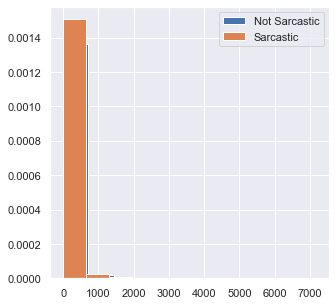

In [71]:
plotDistr('char')

In [72]:
# Number of punctuation symbols
red_copy['punct'] = red_copy['parent_comment'].str.findall(r'[^a-zA-Z\d\s:]').str.len()
red_copy.head()

,label,subreddit,parent_comment,char,punct
188065,0,brisbane,Someone doesn't like scooters,29,1
90121,0,wow,Prolonged Potions VS Old War Potions,36,0
180359,0,minines,NUTS FOR NINTENDO special on ABC news 20/20 fr...,93,2
406760,1,TumblrInAction,He has clearly been through some kind of menta...,104,1
786825,1,india,If he was realy innocent he wud hv insisted on...,260,2


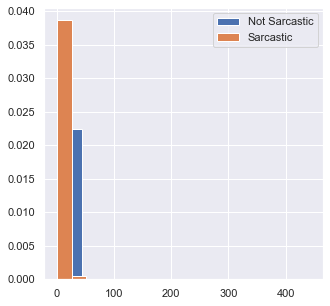

In [73]:
plotDistr('punct')

In [74]:
# Find the number of tokens for each string in the red_sample dataset
red_copy['tokens'] = red_copy['parent_comment'].str.split().str.len()
red_copy.head()

,label,subreddit,parent_comment,char,punct,tokens
188065,0,brisbane,Someone doesn't like scooters,29,1,4
90121,0,wow,Prolonged Potions VS Old War Potions,36,0,6
180359,0,minines,NUTS FOR NINTENDO special on ABC news 20/20 fr...,93,2,16
406760,1,TumblrInAction,He has clearly been through some kind of menta...,104,1,17
786825,1,india,If he was realy innocent he wud hv insisted on...,260,2,47


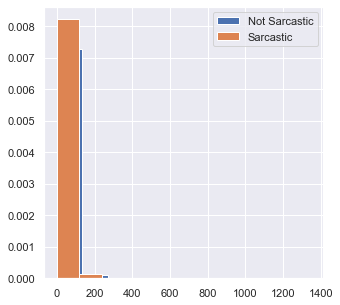

In [75]:
plotDistr('tokens')

In [76]:
# Cleaning the text of the parents' comments
stemmer = SnowballStemmer("english")

def cleanText(x):
    words = [stemmer.stem(word) for word in nltk.word_tokenize(x.lower()) if word.isalpha() and word not in stopwords.words("english")]
    return " ".join(words)

In [77]:
from timeit import default_timer as timer

# get the starting time
startTime = timer()

red_copy["clean"] = red_copy["parent_comment"].apply(cleanText)
red_copy.head()
endTime = timer()

In [78]:
# Get the time needed for stemming all the parent comments and return the cleared texts
print("Time needed to clear the comments is: {} minutes and {:.1f} seconds".format((endTime - startTime)//60, (endTime - startTime)%60))

Time needed to clear the comments is: 8.0 minutes and 19.5 seconds


## Wordcloud

WordCloud is a technique to show which words are the most frequent among the given text.
We start with only one comment:

In [79]:
red_copy.reset_index(inplace=True)
red_copy.drop(['index'], axis=1, inplace=True)
red_copy.head()

,label,subreddit,parent_comment,char,punct,tokens,clean
0,0,brisbane,Someone doesn't like scooters,29,1,4,someon like scooter
1,0,wow,Prolonged Potions VS Old War Potions,36,0,6,prolong potion vs old war potion
2,0,minines,NUTS FOR NINTENDO special on ABC news 20/20 fr...,93,2,16,nut nintendo special abc news someth familiar
3,1,TumblrInAction,He has clearly been through some kind of menta...,104,1,17,clear kind mental breakdown probabl need sympa...
4,1,india,If he was realy innocent he wud hv insisted on...,260,2,47,reali innoc wud hv insist thorough investig de...


In [80]:
red_copy.rename(columns={'parent_comment':'parent'}, inplace=True)
red_copy.head()

,label,subreddit,parent,char,punct,tokens,clean
0,0,brisbane,Someone doesn't like scooters,29,1,4,someon like scooter
1,0,wow,Prolonged Potions VS Old War Potions,36,0,6,prolong potion vs old war potion
2,0,minines,NUTS FOR NINTENDO special on ABC news 20/20 fr...,93,2,16,nut nintendo special abc news someth familiar
3,1,TumblrInAction,He has clearly been through some kind of menta...,104,1,17,clear kind mental breakdown probabl need sympa...
4,1,india,If he was realy innocent he wud hv insisted on...,260,2,47,reali innoc wud hv insist thorough investig de...


Someone doesn't like scooters


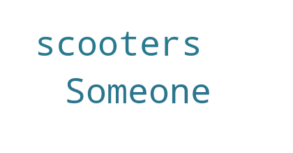

In [81]:
# Start with the first parent comment:
from wordcloud import WordCloud
parent = red_copy.parent[0]
print(parent)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(parent)

# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Wordcloud on all the parent comments:

In [82]:
# Wordcloud
def myWordCloud(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_copy['parent'][red_copy["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

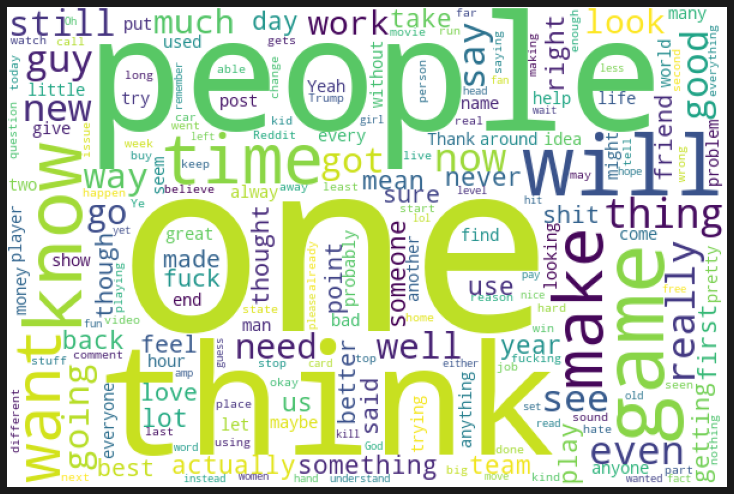

In [83]:
## Wordcloud for Non sarcastic comments
myWordCloud(0)

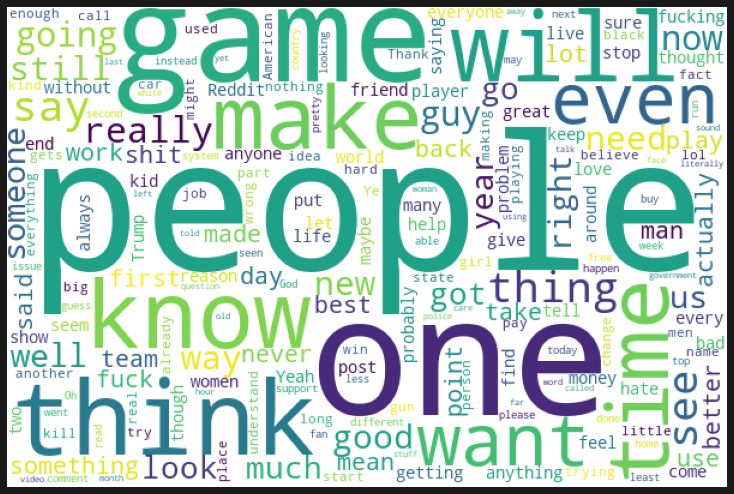

In [84]:
## Wordcloud for Sarcastic comments
myWordCloud(1)

Wordcloud with the cleaned version of the parent comments:

In [85]:
# Word cloud
def myWordCloudCleaned(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_copy['clean'][red_copy["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

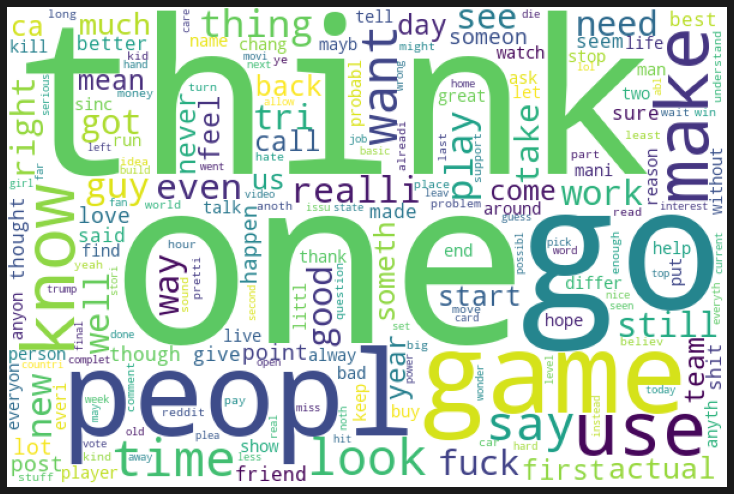

In [86]:
## Wordcloud for Non sarcastic comments
myWordCloudCleaned(0)

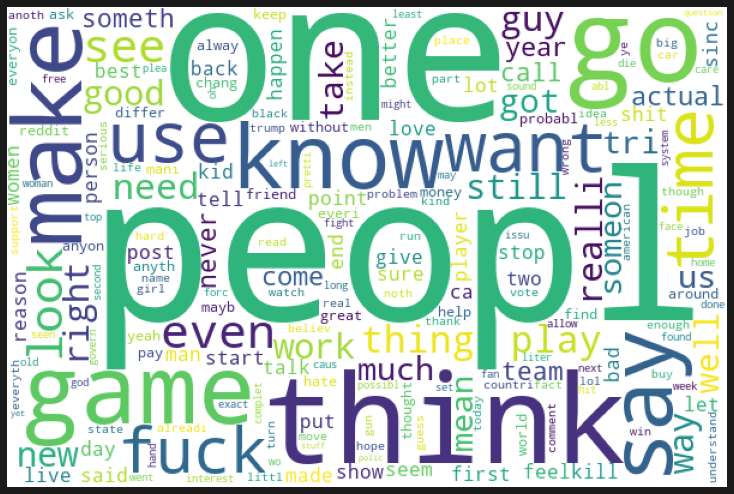

In [87]:
## Wordcloud for Sarcastic comments
myWordCloudCleaned(1)

## Split into train, test and validation set

In [88]:
## Let's check the number of unique values in the subreddit columns
red_sample['subreddit'].nunique()

4068

In [89]:
X = red_copy[['clean','subreddit']]
y = red_copy['label']

In [90]:
X_train, red_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=28)

In [91]:
red_train, red_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=28)

In [92]:
print(red_train.shape)
print(red_val.shape)
print(red_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(32344, 2)
(8087, 2)
(10108, 2)
(32344,)
(8087,)
(10108,)


In [93]:
red_train.head()

,clean,subreddit
20051,hah happen brought attent dock pay next week c...,AdviceAnimals
12971,ca tell troll anymor,programming
41837,power pictur emt tough run,pics
19748,terribl,nba
15527,male femal betta femal betta gallon communiti ...,bettafish


In [94]:
red_val.head()

,clean,subreddit
42280,even know made peopl spread,AskReddit
45359,weight fluctuat much regular basi would meanin...,nfl
34031,first angri leagu anyth second wolv lotteri ot...,nba
33395,game still peopl downvot guy tri help,KansasCityChiefs
29704,trump,atheism


## Classification algorithms: First alternative
In the first alternative we wll have separate Tf-Idf vectorizers for comments and for subreddits.

#### TF-IDF on cleaned parent comments

TF-IDF focusing on the parent comments from which we have removed the punctuation and on which we have performed stemmization. 

In [126]:
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer

In [127]:
parent_vectorizer = TfidfVectorizer(ngram_range=(1,2))
subreddits_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

In [135]:
clean_train = parent_vectorizer.fit_transform(red_train['clean'])
clean_valid = parent_vectorizer.transform(red_val['clean'])
clean_test = parent_vectorizer.transform(red_test['clean'])

In [136]:
subred_train = subreddits_vectorizer.fit_transform(red_train['subreddit'])
subred_valid = subreddits_vectorizer.transform(red_val['subreddit'])
subred_test = subreddits_vectorizer.transform(red_test['subreddit'])

In [137]:
reddit_train = hstack([clean_train, subred_train])
reddit_valid = hstack([clean_valid, subred_valid])
reddit_test = hstack([clean_test, subred_test])

In [138]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
NB = MultinomialNB()
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [139]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

#### Naive Bayes

In [140]:
naive_bayes = NB.fit(reddit_train, y_train)

In [141]:
naiveBayes_predict = naive_bayes.predict(reddit_test)

In [142]:
metrics.accuracy_score(y_test, naiveBayes_predict)

0.5709339137316977

Cross Validation:

In [143]:
NB_cv = cross_val_score(NB, reddit_train, y_train, n_jobs = -1)
NB_cv

array([0.5707219 , 0.55835523, 0.56546607, 0.56948524, 0.55983302])

#### Logistic Regression

In [144]:
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)

In [145]:
## Fit the model
logit.fit(reddit_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    5.0s finished


LogisticRegression(C=1, n_jobs=4, random_state=17, verbose=1)

In [146]:
from sklearn.metrics import roc_auc_score, confusion_matrix
roc_auc_score(y_test, logit.predict_proba(reddit_test)[:,1])

0.5991304026763755

In [147]:
logit.predict_proba(reddit_test)[:,1]

array([0.482646  , 0.37379678, 0.51208939, ..., 0.39609204, 0.48510893,
       0.58853445])

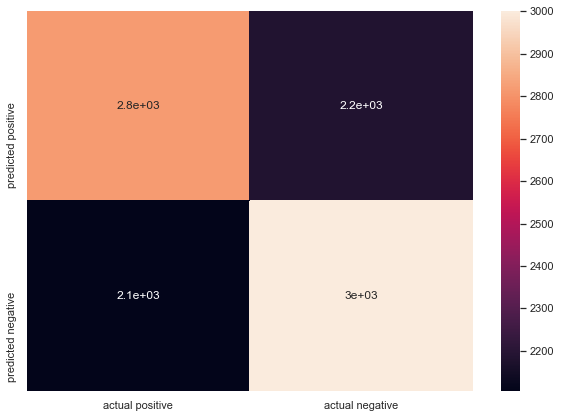

In [148]:
conf_mat = pd.DataFrame(confusion_matrix(y_test, logit.predict(reddit_test)), index = ['predicted positive', 'predicted negative'],
                  columns = ['actual positive', 'actual negative'])
plt.figure(figsize = (10,7))
sns.heatmap(conf_mat, annot=True)
plt.show()

#### Random Forest

In [149]:
random_forest = RandomForestClassifier(max_depth=10, max_features=10)
random_forest.fit(reddit_train, y_train)

RandomForestClassifier(max_depth=10, max_features=10)

In [150]:
randomForest_predict = random_forest.predict(reddit_test)

In [151]:
metrics.accuracy_score(y_test, randomForest_predict)

0.5138504155124654

Cross Validation:

In [152]:
rf_cv = cross_val_score(random_forest, reddit_train, y_train, n_jobs = -1)
rf_cv

array([0.51507188, 0.5102798 , 0.51259855, 0.50069563, 0.50309215])

### Let's try with a new sentence
We decided to try with two questions from AskReddit

In [153]:
sent1 = {'subreddit': ['AskReddit'], 'parent': ['What is your dream job? (Serious)']}
proof = pd.DataFrame(sent1)

In [154]:
proof

,subreddit,parent
0,AskReddit,What is your dream job? (Serious)


In [155]:
X_sub1 = subreddits_vectorizer.transform(proof['subreddit'])
X_parent1 = parent_vectorizer.transform(proof['parent'])
X_sent1 = hstack([X_sub1, X_parent1])

In [156]:
X_sent1

<1x313816 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in COOrdinate format>

In [157]:
NB.predict_proba(X_sent1)

array([[0.52904924, 0.47095076]])

In [158]:
logit.predict_proba(X_sent1)

array([[0.55639802, 0.44360198]])

## Second Alternative

Adding the subreddit to the comment and therefore conduct the analysis on the combination of the two: since the subreddits are not classified as stopwords when parsing the comments they should not be removed, thus appearing in the cleaned version of the comments.

In [159]:
red_copy.head()

,label,subreddit,parent,char,punct,tokens,clean
0,0,brisbane,Someone doesn't like scooters,29,1,4,someon like scooter
1,0,wow,Prolonged Potions VS Old War Potions,36,0,6,prolong potion vs old war potion
2,0,minines,NUTS FOR NINTENDO special on ABC news 20/20 fr...,93,2,16,nut nintendo special abc news someth familiar
3,1,TumblrInAction,He has clearly been through some kind of menta...,104,1,17,clear kind mental breakdown probabl need sympa...
4,1,india,If he was realy innocent he wud hv insisted on...,260,2,47,reali innoc wud hv insist thorough investig de...


In [160]:
red_copy['text'] = red_copy.clean + " " + red_copy.subreddit
red_copy.head()

,label,subreddit,parent,char,punct,tokens,clean,text
0,0,brisbane,Someone doesn't like scooters,29,1,4,someon like scooter,someon like scooter brisbane
1,0,wow,Prolonged Potions VS Old War Potions,36,0,6,prolong potion vs old war potion,prolong potion vs old war potion wow
2,0,minines,NUTS FOR NINTENDO special on ABC news 20/20 fr...,93,2,16,nut nintendo special abc news someth familiar,nut nintendo special abc news someth familiar ...
3,1,TumblrInAction,He has clearly been through some kind of menta...,104,1,17,clear kind mental breakdown probabl need sympa...,clear kind mental breakdown probabl need sympa...
4,1,india,If he was realy innocent he wud hv insisted on...,260,2,47,reali innoc wud hv insist thorough investig de...,reali innoc wud hv insist thorough investig de...


In [161]:
def myWordCloudText(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_copy['text'][red_copy["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

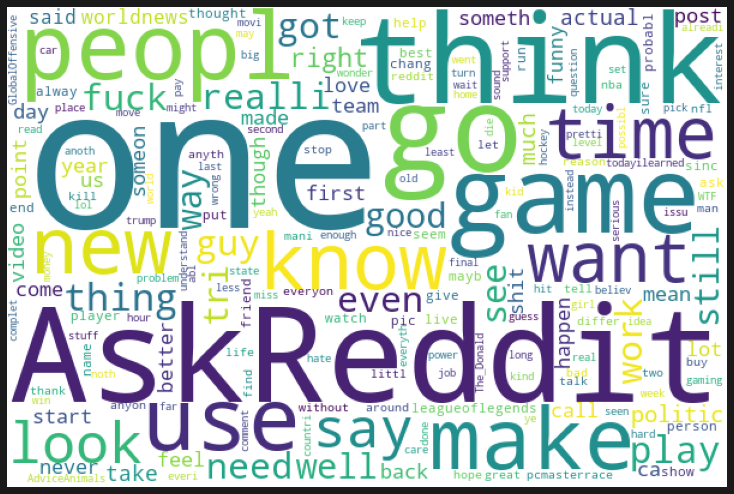

In [162]:
## Wordcloud for Non sarcastic comments
myWordCloudText(0)

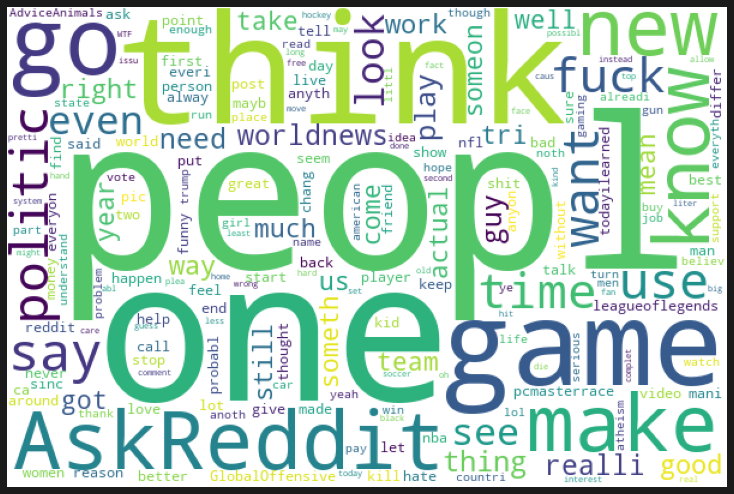

In [163]:
## Wordcloud for Non sarcastic comments
myWordCloudText(1)

In [211]:
X2 = red_copy[['text']]
y2 = red_copy['label']

In [212]:
X2

,text
0,someon like scooter brisbane
1,prolong potion vs old war potion wow
2,nut nintendo special abc news someth familiar ...
3,clear kind mental breakdown probabl need sympa...
4,reali innoc wud hv insist thorough investig de...
...,...
50534,calm dude bradi multimillionair marri multimil...
50535,yeah wait hoth battl wv awhil unfortun still h...
50536,welcom similar stunt feel news first broke eve...
50537,sander clinton yes trump foreign polici idea s...


In [213]:
X_train2, red_test2, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=28)

In [214]:
clean_train2 = parent_vectorizer.fit_transform(X_train2['text'])
clean_test2 = parent_vectorizer.transform(red_test2['text'])

#### Naive Bayes

In [167]:
naive_bayes2 = NB.fit(clean_train2, y2_train)

In [168]:
naiveBayes_predict2 = naive_bayes2.predict(clean_test2)

In [169]:
metrics.accuracy_score(y2_test, naiveBayes_predict2)

0.5695488721804511

Cross Validation:

In [170]:
NB_cv2 = cross_val_score(NB, clean_train2, y2_train, n_jobs = -1)
NB_cv2

array([0.55991097, 0.56480336, 0.56888449, 0.56789513, 0.56702943])

#### Random forest

In [171]:
random_forest2 = RandomForestClassifier(max_depth=10, max_features=10)
random_forest2.fit(clean_train2, y2_train)

RandomForestClassifier(max_depth=10, max_features=10)

In [172]:
randomForest_predict2 = random_forest2.predict(clean_test2)

In [173]:
metrics.accuracy_score(y2_test, randomForest_predict2)

0.5069252077562327

Cross Validation:

In [174]:
rf_cv2 = cross_val_score(random_forest2, clean_train2, y2_train, n_jobs = -1)
rf_cv2

array([0.50265859, 0.50197873, 0.49938165, 0.49814494, 0.49678457])

#### Logistic Regression

In [175]:
X2 = red_copy['text']
y2 = red_copy['label']

In [176]:
X_train2, red_test2, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=28)

In [177]:
from sklearn.pipeline import Pipeline
tf_idf2 = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf2), 
                                 ('logit', logit)])

In [178]:
tfidf_logit_pipeline.fit(X_train2, y2_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.9s finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=17,
                                    verbose=1))])

In [179]:
roc_auc_score(y2_test, tfidf_logit_pipeline.predict_proba(red_test2)[:,1])

0.589898392386093

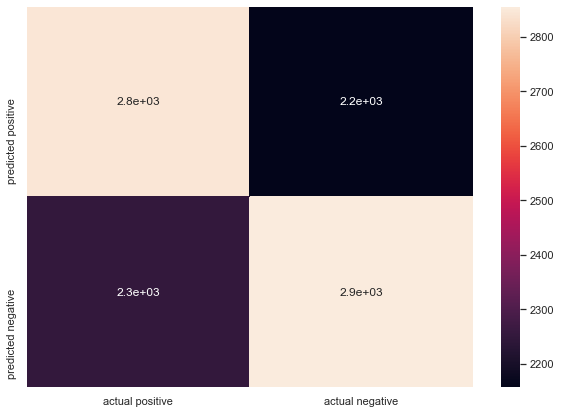

In [180]:
conf_mat2 = pd.DataFrame(confusion_matrix(y2_test, tfidf_logit_pipeline.predict(red_test2)), index = ['predicted positive', 'predicted negative'],
                  columns = ['actual positive', 'actual negative'])
plt.figure(figsize = (10,7))
sns.heatmap(conf_mat2, annot=True)
plt.show()

### Let's make an example

In [225]:
sent2 = {'text': ['AskReddit: What is your dream job? (Serious)']}
proof2 = pd.DataFrame(sent2)

In [226]:
proof2

,text
0,AskReddit: What is your dream job? (Serious)


In [227]:
X_parent2 = parent_vectorizer.transform(proof2['text'])

In [229]:
naive_bayes2.predict_proba(X_parent2)

array([[0.74289415, 0.25710585]])

In [230]:
X_parent2 = tf_idf2.transform(proof2['text'])

In [231]:
logit.predict_proba(X_parent2)

array([[0.8112616, 0.1887384]])

#### GridSeachCV:

In [181]:
model = Pipeline([('tfidf',TfidfVectorizer(min_df=2)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
parameters = {'tfidf__ngram_range':[(1,1),(1,2)],'tfidf__use_idf':(True,False)}

In [182]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=parameters, verbose=2,n_jobs=-1, cv=3, refit=True)

In [183]:
grid.fit(X_train2, y2_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    4.9s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.2s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2)),
                                       ('logit',
                                        LogisticRegression(max_iter=3000))]),
             n_jobs=-1,
             param_grid={'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__use_idf': (True, False)},
             verbose=2)

In [184]:
chosen_model = Pipeline([('tfidf',TfidfVectorizer(min_df=2, ngram_range=(1,2),use_idf=True)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
chosen_model.fit(X_train2, y2_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('logit', LogisticRegression(max_iter=3000))])

In [185]:
from sklearn.metrics import accuracy_score
predictions = chosen_model.predict(red_test2)
print('Accuracy Score: {:.2%}'.format(accuracy_score(y2_test,predictions)),'\n')

Accuracy Score: 56.63% 



## PCA Analysis for dimensionality reduction

https://www.datacamp.com/community/tutorials/categorical-data

In [186]:
category = red_copy['subreddit'].astype('category').cat.categories.tolist()
replace_sub = {'subreddit' : {k: v for k,v in zip(category, list(range(1,len(category)+1)))}}

In [187]:
red_copy.replace(replace_sub, inplace=True)

In [188]:
red_copy.head()

,label,subreddit,parent,char,punct,tokens,clean,text
0,0,2305,Someone doesn't like scooters,29,1,4,someon like scooter,someon like scooter brisbane
1,0,4033,Prolonged Potions VS Old War Potions,36,0,6,prolong potion vs old war potion,prolong potion vs old war potion wow
2,0,3172,NUTS FOR NINTENDO special on ABC news 20/20 fr...,93,2,16,nut nintendo special abc news someth familiar,nut nintendo special abc news someth familiar ...
3,1,1879,He has clearly been through some kind of menta...,104,1,17,clear kind mental breakdown probabl need sympa...,clear kind mental breakdown probabl need sympa...
4,1,2933,If he was realy innocent he wud hv insisted on...,260,2,47,reali innoc wud hv insist thorough investig de...,reali innoc wud hv insist thorough investig de...


In [189]:
## TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3)
R = vectorizer.fit_transform(red_copy["clean"])
print(R.shape)
type(R)

(50539, 34402)


scipy.sparse.csr.csr_matrix

In [190]:
#L = vectorizer.fit_transform(red_copy["subreddit"])
#print(R.shape)
#type(R)

In [191]:
# We can use hstack to merge two sparse matrices, without having to convert to dense format.
def addFeature(R, feature_to_add):  
    return hstack([R, csr_matrix(feature_to_add).T], 'csr')

In [192]:
R = addFeature(R, red_copy['subreddit'])

In [193]:
print(R.shape)

(50539, 34403)


In [194]:
features = np.append(vectorizer.get_feature_names(), ['Sub'])

In [195]:
features

array(['aa', 'aaa', 'aaaaand', ..., 'zuckerberg', 'zulrah', 'Sub'],
      dtype='<U19')

In [196]:
y_label = red_copy['label']

In [197]:
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=20) 
R_new = selector.fit_transform(R, y_label)
print(R_new.shape)

(50539, 20)


In [198]:
features[selector.get_support()]

array(['appar', 'ban', 'blame', 'gay', 'gun', 'irl', 'men', 'peopl',
       'polic', 'protest', 'racism', 'racist', 'rape', 'riot', 'sarcasm',
       'sarcast', 'sexist', 'thank', 'women', 'Sub'], dtype='<U19')

In [199]:
# compute chi2 scores for features and sort them from most to less relevant
from sklearn.feature_selection import chi2
stat, pval = chi2(R,y_label)
score = list(zip(features, stat, pval))
score.sort(key = lambda tup: tup[2])
score

[('Sub', 76832.56415543772, 0.0),
 ('sarcasm', 19.881458256427806, 8.239560503803054e-06),
 ('racist', 19.022099708828037, 1.292132370512365e-05),
 ('women', 15.134661177497337, 0.00010010832496439122),
 ('peopl', 13.530913413990724, 0.00023466580640813962),
 ('polic', 11.595338183686158, 0.0006611734991194002),
 ('irl', 11.195139784746804, 0.0008201185921700941),
 ('rape', 11.011282014371655, 0.0009055898953796663),
 ('racism', 10.733389850466335, 0.001052195170358161),
 ('men', 10.618888481080244, 0.001119383129632801),
 ('protest', 9.83289963769866, 0.0017141790771809115),
 ('sexist', 9.615658362731608, 0.0019292528753700128),
 ('thank', 9.193650744128178, 0.0024285603596687537),
 ('sarcast', 8.2937982640817, 0.003978069634648552),
 ('appar', 7.998248319855147, 0.004682262454691745),
 ('ban', 7.43420618950878, 0.006399558642627232),
 ('riot', 6.920440746274654, 0.008521597059406475),
 ('blame', 6.8359676691309, 0.008934028243960333),
 ('gun', 6.82124175797242, 0.00900799131128133),


In [200]:
# select features with p-val less than 1%
sel = np.flatnonzero(pval < 0.01)
R_sel = R[:,sel]
features_sel = features[sel]
R_sel

<50539x19 sparse matrix of type '<class 'numpy.float64'>'
	with 57924 stored elements in Compressed Sparse Row format>

In [201]:
# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
R_scale = scaler.fit_transform(R_sel.toarray())

In [202]:
# PCA
from sklearn.decomposition import PCA

pca = PCA().fit(R_scale)
nc  = list(range(1,1+len(pca.explained_variance_ratio_)))
ev  = np.cumsum(pca.explained_variance_ratio_)
plt.plot(nc, ev)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

LinAlgError: SVD did not converge